<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/P0_BigMonksDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de frailejones (Big Monks Detection)
**Proyecto Deep Learning** - Redes Neuronales para clasificación de imágenes

**Profesor:** Sergio Alberto Mora Pardo

**Integrantes:**

*   Daniel Rodríguez
*   Diana Ibáñez
*   Eduardo Correcha
*   Erika Cárdenas
*   Paola Castro


**Objetivos:**
1. Calcular la cantidad de frailejones en la imagen.
2. Calcular la densidad poblacional de los frailejones en la imagen.

In [ ]:
!pip install livelossplot

In [ ]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import random

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
import urllib.request
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import HeNormal, GlorotNormal
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras


## Cargue de datos

Cargue de la imagen `IMG_3451.JPG` a procesar.

## Caso Aplicado

### Cálculo de cantidad de Frilejones

Aplicar al menos 5 modelos, se estiman los siguientes valores como resultado del entrenamiento:



*   Sencilla --> 0.88
*   Multi-capa --> 0.95
*  Convolucional --> 0.95
*  Convolucional + VGG16 --> 0.99



3. Implementa una red neuronal convolucional

Se importan los datos antes de ser aplanados para que puedan ser procesados por la red neuronal convolucional

In [17]:
import numpy as np
import h5py
import urllib.request

def import_imagenes():
    urllib.request.urlretrieve("https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/data_F", "data_F")
    FF = h5py.File('data_F', 'r')

    CTF = FF.get('Frailejon')
    fraile = np.array(CTF)

    CTNF = FF.get('NoFrailejon')
    nofraile = np.array(CTNF)

    # Tomar el número de ejemplos para cada clase
    n = fraile.shape[0]
    m = nofraile.shape[0]

    # Inicializar listas para los ejemplos de cada clase
    fraile2 = []
    nofraile2 = []

    r = m
    for l in range(2):
        if l == 1:
            r = n
        for i in range(0, r, 1):
            for j in range(0, 5, 1):
                if j == 0:
                    r1 = 0
                    c1 = 0
                    r2 = 70
                    c2 = 70
                elif j == 1:
                    r1 += 30
                    r2 += 30
                elif j == 2:
                    c1 += 30
                    c2 += 30
                elif j == 3:
                    r1 = 0
                    r2 = 70
                elif j == 4:
                    r1 = 15
                    c1 = 15
                    r2 = 85
                    c2 = 85

                # Extraer subimágenes
                if l == 0:
                    x = nofraile[i, r1:r2, c1:c2, :]
                    nofraile2.append(x)
                if l == 1:
                    x = fraile[i, r1:r2, c1:c2, :]
                    fraile2.append(x)

    nofraile2 = np.asarray(nofraile2)
    fraile2 = np.asarray(fraile2)

    CT_x2 = np.concatenate((fraile2, nofraile2))

    CT_x_columna = CT_x2.reshape(CT_x2.shape[0], -1).T
    CT_xn = CT_x_columna / 255.0

    CT_y = np.array([1] * fraile2.shape[0] + [0] * nofraile2.shape[0])
    CT_y = np.vstack(CT_y).T

    return CT_x2, CT_xn, CT_y

# Llamar a la función y extraer datos
CT_x2, CT_xn, CT_y = import_imagenes()

# Guardar el array de imágenes antes de aplanarlas
np.save('CT_x2.npy', CT_x2)

In [24]:
CT_x2 = CT_x2 / 255.0  #Se realiza la escalación de los datos para una mejor comprensión en el modelo

In [18]:
CT_x2.shape

(250, 70, 70, 3)

In [19]:
Y = CT_y.reshape(-1)

In [20]:
Y.shape

(250,)

In [21]:
# Dividir los datos en 80% para entrenamiento y 30% para prueba
X_train, X_test, Y_train, Y_test = train_test_split(CT_x2, Y, test_size=0.3, random_state=42)

In [22]:
# Verificar las formas de los conjuntos de entrenamiento y prueba
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (175, 70, 70, 3)
Shape of X_test: (75, 70, 70, 3)
Shape of Y_train: (175,)
Shape of Y_test: (75,)


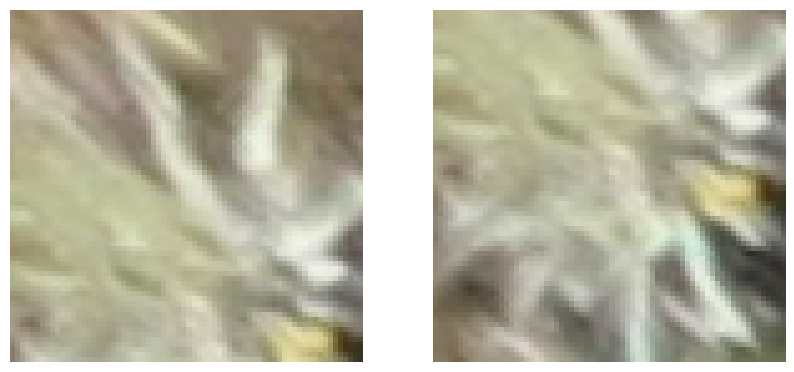

In [25]:
plt.figure(figsize=(10, 15))
for image_idx in (0, 1):
    plt.subplot(1, 2, image_idx + 1)
    plt.imshow(CT_x2[image_idx])
    plt.axis("off")

plt.show()

In [27]:
model2 = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[70, 70, 3]), #Filtros o kernels
    tf.keras.layers.BatchNormalization(), #BatchNormalization: Normaliza las activaciones de la capa anterior, asegurando que tengan media 0 y desviación estándar 1 para estabilizar y acelerar el entrenamiento.
    tf.keras.layers.MaxPool2D(),
    # Añadir BatchNorm después de las capas convolucionales
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [28]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model2.compile(optimizer='adam',
              loss='binary_crossentropy',  # Cambiar a 'categorical_crossentropy' si es multiclase
              metrics=['accuracy','auc'])


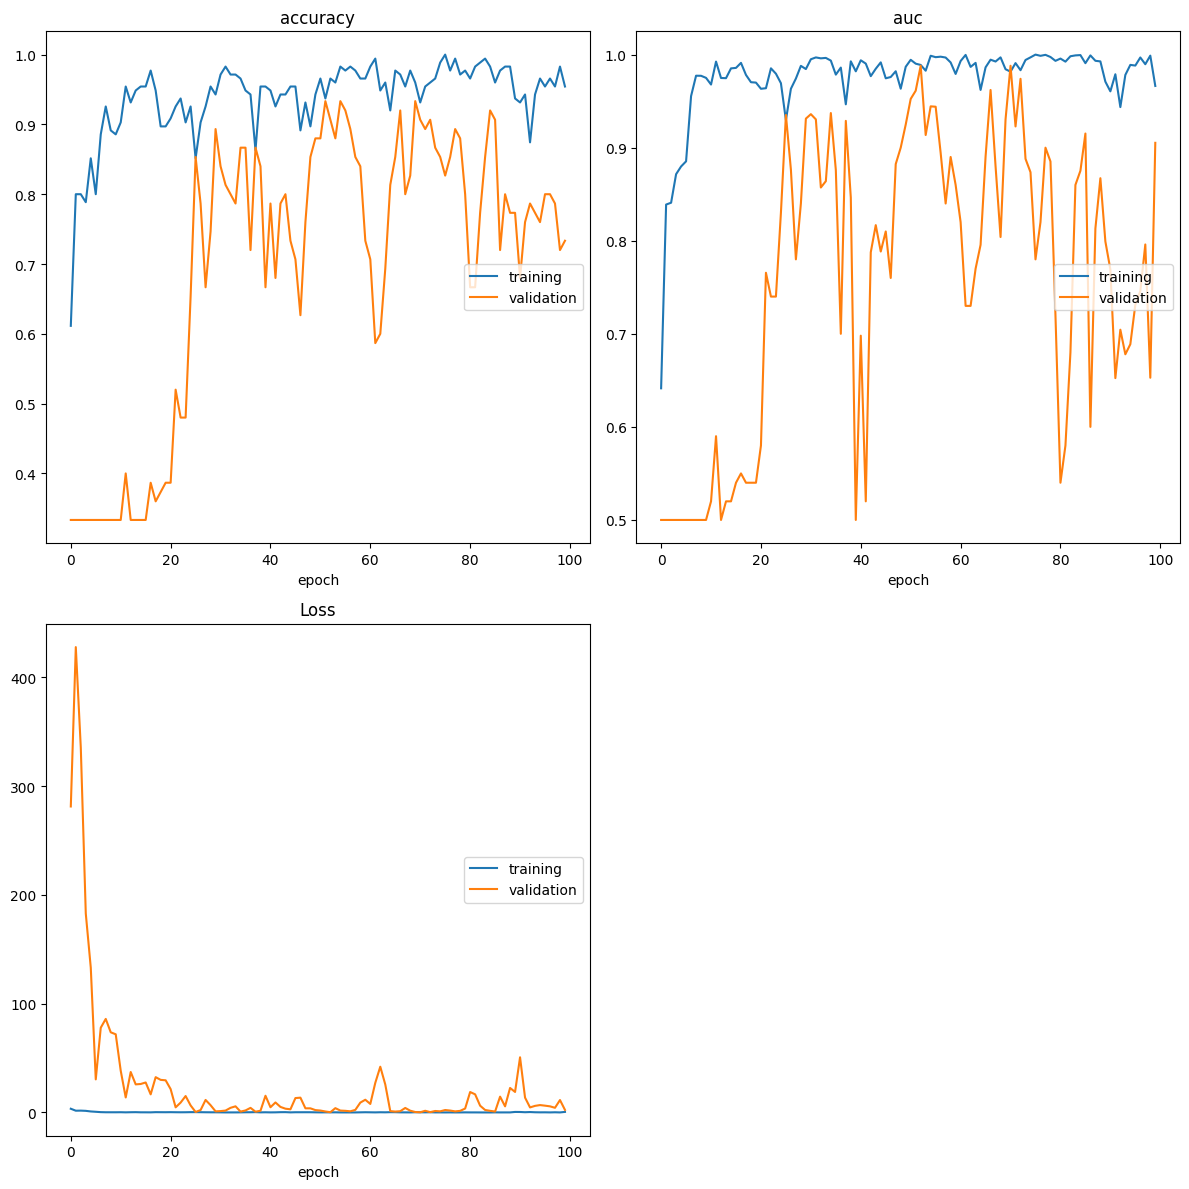

accuracy
	training         	 (min:    0.611, max:    1.000, cur:    0.954)
	validation       	 (min:    0.333, max:    0.933, cur:    0.733)
auc
	training         	 (min:    0.641, max:    1.000, cur:    0.966)
	validation       	 (min:    0.500, max:    0.988, cur:    0.905)
Loss
	training         	 (min:    0.027, max:    3.442, cur:    0.536)
	validation       	 (min:    0.178, max:  427.828, cur:    2.356)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.9476 - auc: 0.9594 - loss: 0.7499 - val_accuracy: 0.7333 - val_auc: 0.9052 - val_loss: 2.3555


In [29]:
# Entrenar el modelo
history = model2.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=100,
                    batch_size=32,
                    callbacks=[PlotLossesKeras()])

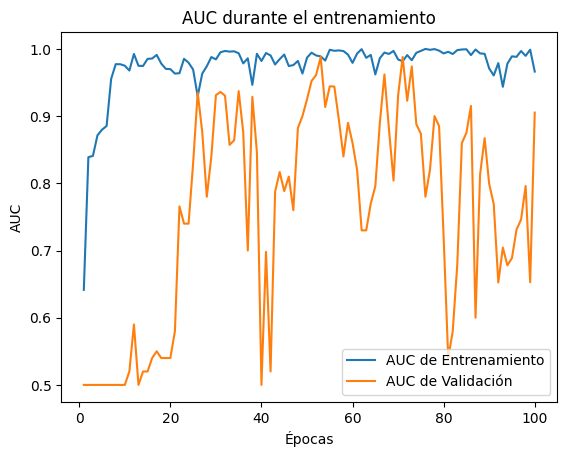

In [30]:
# Obtener los valores del AUC para entrenamiento y validación
train_auc = history.history ['auc']
val_auc = history.history['val_auc']

# Graficar el AUC
epochs = range(1, len(train_auc) + 1)

plt.plot(epochs, train_auc, label='AUC de Entrenamiento')
plt.plot(epochs, val_auc, label='AUC de Validación')
plt.title('AUC durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.show()

Se introduce tf.keras.layers.GlobalAveragePooling2D(),antes de las últimas capas y se observa una mejora en el rendimiento del modelo

In [32]:
model3 = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[70, 70, 3]),  # Filtros o kernels
    tf.keras.layers.BatchNormalization(),  # Normalización para estabilizar y acelerar el entrenamiento
    tf.keras.layers.MaxPool2D(),  # Reducción de la dimensionalidad espacial
    # Añadir BatchNorm después de las capas convolucionales
    DefaultConv2D(filters=128, padding="same", strides=2),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),  # Reducción global de las características espaciales
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")  # Capa de salida para clasificación binaria
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

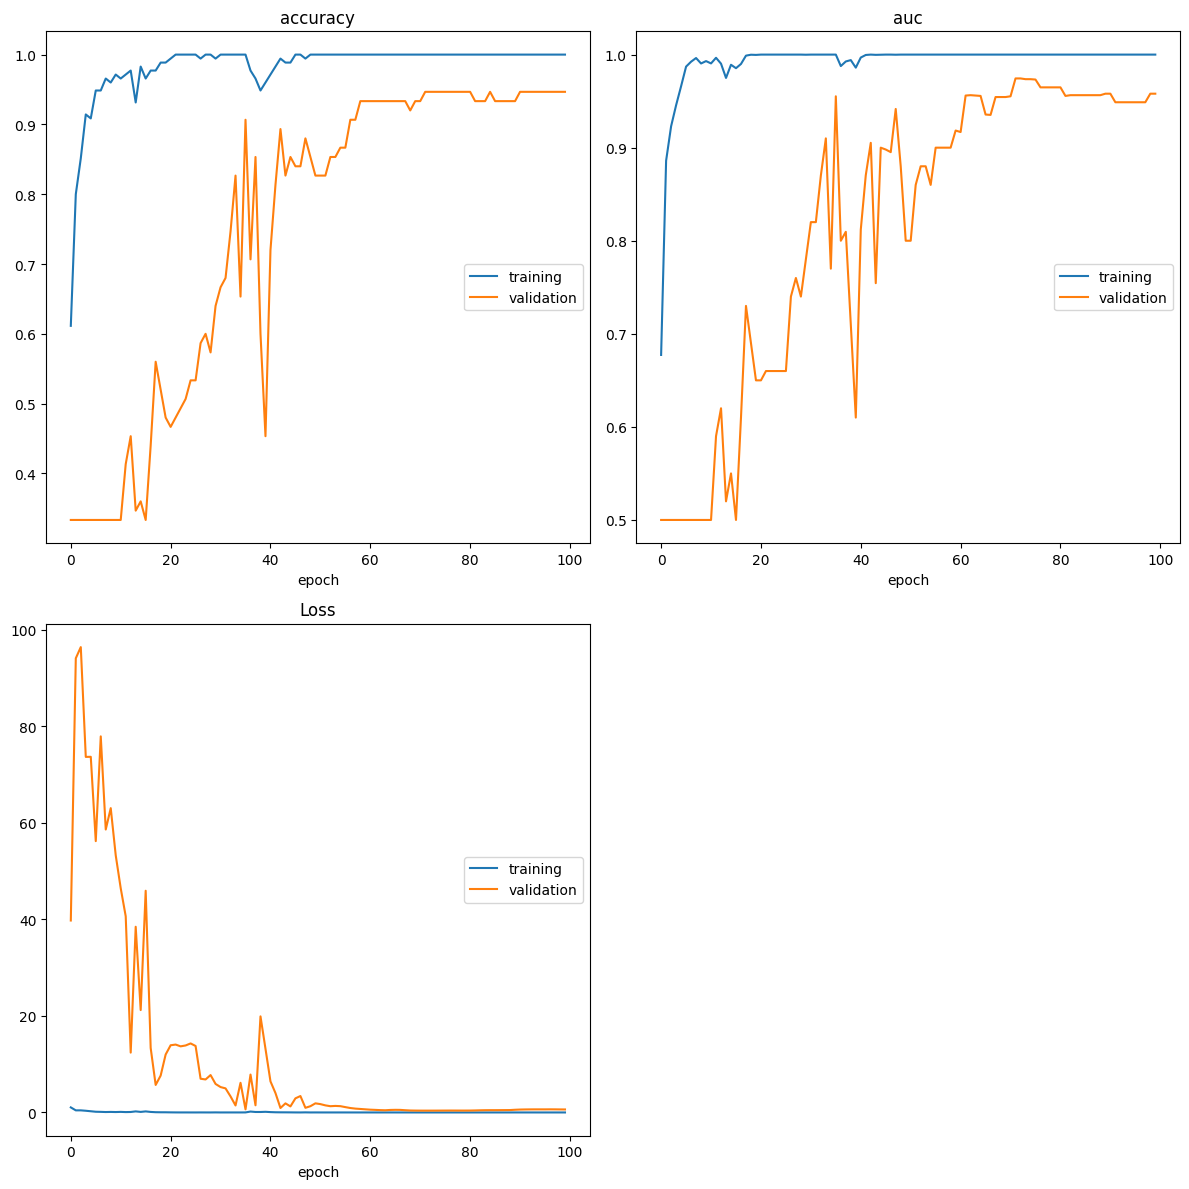

accuracy
	training         	 (min:    0.611, max:    1.000, cur:    1.000)
	validation       	 (min:    0.333, max:    0.947, cur:    0.947)
auc
	training         	 (min:    0.677, max:    1.000, cur:    1.000)
	validation       	 (min:    0.500, max:    0.974, cur:    0.958)
Loss
	training         	 (min:    0.000, max:    1.046, cur:    0.000)
	validation       	 (min:    0.378, max:   96.400, cur:    0.621)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.0736e-05 - val_accuracy: 0.9467 - val_auc: 0.9580 - val_loss: 0.6212


In [34]:
# Entrenar el modelo
history = model3.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=100,
                    batch_size=32,
                    callbacks=[PlotLossesKeras()])

In [38]:
model4 = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[70, 70, 3]),  # Filtros o kernels
    tf.keras.layers.BatchNormalization(),  # Normalización para estabilizar y acelerar el entrenamiento
    tf.keras.layers.MaxPool2D(),  # Reducción de la dimensionalidad espacial
    # Añadir BatchNorm después de las capas convolucionales
    DefaultConv2D(filters=128, padding="same", strides=2),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),  # Reducción global de las características espaciales
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")  # Capa de salida para clasificación binaria
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
